In [4]:
import numpy as np
import art
import torchvision
from torchvision import transforms as transforms
from PIL import Image
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Loading models, both of them are pretrained on COCO dataset <br />
Here is link to model documentation: https://pytorch.org/vision/stable/models.html#faster-r-cnn

In [6]:
#basic art object_detection estimator in torch
art.estimators.object_detection.PyTorchFasterRCNN()

PyTorchFasterRCNN(channel_index=<art.utils._Deprecated object at 0x00000231F0145E10>, channels_first=None, model=FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [7]:
# model from torch
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
print(model)
# these two network are the same

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [8]:
#we can train torch model and pass is to art_estimator
art_model = art.estimators.object_detection.PyTorchFasterRCNN(model = model, clip_values=[0,255])

Check basic usage of network, we give a random image and check what it returns.
It sometimes will detect something in this random image and we can look at the output.
Also we will use GPU if possible

In [9]:
inputs = torch.randn([3, 3456, 4608])
# checking for cuda 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = inputs.to(device)
out = model([inputs])
print(out)

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)}]


Let's read a real image and get them to our model

In [10]:
image = Image.open("giraffe.jpg").convert('RGB')

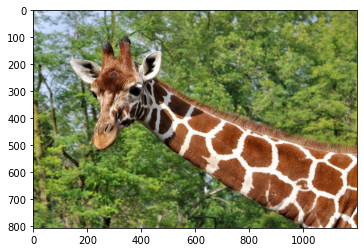

In [11]:
imgplot = plt.imshow(image)
plt.show()

In [12]:
giraffe_tensor = transforms.ToTensor()(image)
print(giraffe_tensor.shape)
giraffe_tensor = giraffe_tensor.to(device)

torch.Size([3, 806, 1200])


In [28]:
out = model([giraffe_tensor])
print(out)
label = out[0]['labels'].item()
print(label)

[{'boxes': tensor([[ 152.9368,   89.7184, 1188.7885,  796.6898]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([25], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0', grad_fn=<IndexBackward>)}]
25


Ok, our network detects something in the picture let's check if label: 25 is for giraffes

In [29]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [30]:
print(COCO_INSTANCE_CATEGORY_NAMES[label])

giraffe


We can put an np.array image directly to our model and get appropriate output

In [18]:
image2 = Image.open("giraffe2.jpg").convert('RGB')
img_arr = np.array(image2)
img_arr = np.expand_dims(img_arr, 0)
print(img_arr.shape)
predictions = art_model.predict(img_arr)
print(predictions)

(1, 1067, 1600, 3)
[{'boxes': array([[ 693.65924,  174.52498, 1477.9994 , 1055.1589 ],
       [ 510.11496,  224.5522 , 1065.5365 , 1061.4241 ],
       [ 682.52734,  412.9922 , 1116.4353 , 1037.0057 ]], dtype=float32), 'labels': array([25, 25, 25], dtype=int64), 'scores': array([0.99933916, 0.997769  , 0.13987716], dtype=float32)}]


Now we can add predicted boxes to our picture <br/>
TODO of course we will use output from art

In [20]:
attackDPatch = art.attacks.evasion.DPatch(art_model)
attackRobustDPatch = art.attacks.evasion.RobustDPatch(art_model)

In [22]:
print(attackDPatch)
print(attackRobustDPatch)